**XGBoost**
- leading model for working with standard tabular data (ex. Pandas DataFrames)
- require more knowledge and model tuning to reach peak accuracy
- implementation of the Gradient Boosted Decision Trees algorithm

**Gradient Boosted Decision Trees Algorithm**
-  go through cycles that repeatedly builds new models and combines them into an ensemble model. 

[Install XGBoost](https://anaconda.org/anaconda/py-xgboost) - conda install -c anaconda py-xgboost (for Windows)

Note: Research more about XGBoost

In [1]:
# Import libraries: pandas, scikit-learn, xgboost
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import GridSearchCV

import xgboost as xgb
#from xgboost import XGBRegressor
#from xgboost import DMatrix

In [2]:
# Dataset: Home prices in iowa
iowa_file_path = "./data/iowa_home_filtered.csv"

# Read filtered csv file. Remove index in first column index_col=0
iowa_data = pd.read_csv(iowa_file_path, index_col=0)

In [3]:
# Select features and target
y = iowa_data.SalePrice
X = iowa_data.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object'])

# For cross-validation from xgboost (We'll check scikit-learn cross val for now)
# data_dmatrix = xgb.DMatrix(data=X,label=y)

In [4]:
# Split data to training and validation data
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.7, 
                                                    test_size=0.3, 
                                                    random_state=0)

**Pipelines**

*Overview:* Pipelines are used to make our codes organized. It bundles our data processing and modeling steps into a single one.

Note that we remove the transformer *SimpleImputer* because we already handled missing values.

In [5]:
# Create pipeline
#xgb_pipeline = make_pipeline(SimpleImputer(), XGBRegressor(n_estimators=1000, learning_rate=0.05))

# New way to create pipeline
#xgb_pipeline = Pipeline([('imputer', SimpleImputer()), 
#                         ('xgbrg', XGBRegressor(n_estimators=1000, learning_rate=0.05))])

xgb_pipeline = Pipeline([('xgbrg', xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05))])

**Model Tuning for XGBRegressor**

Parameters that can dramatically affect your model's accuracy and training speed:
1. n_estimators - specifies how many times to go through the modeling cycle
2. early_stopping_rounds - offers a way to automatically find the ideal value
3. learning_rate - instead of getting predictions by simply adding up the predictions from each component model, we will multiply the predictions from each model by a small number before adding them in. This means each tree we add to the ensemble helps us less. In practice, this reduces the model's propensity to overfit.
4. n_jobs - On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine.

There are other parameters but still need to research.

**Cross-validation**

Cross-validation gives us a more reliable measure of model's quality compared to train_test_split on small datasets. It works by dividing our dataset into k-fold or k experiments of data to get k number of measures of model quality where k $\ge$ 1.

In [6]:
# 5-fold cross-validation
fit_params = {'xgbrg__verbose' : False,
              'xgbrg__early_stopping_rounds' : 5,
              'xgbrg__eval_set' :[(X_test.values, y_test)]
             }

scores = cross_val_score(xgb_pipeline, X_train.values, y_train, scoring='neg_mean_absolute_error', cv=5, fit_params=fit_params)
print("On average, our predictions are off by about $ %.2f by using XGBoost" %(-1 * scores.mean()))

On average, our predictions are off by about $ 19209.63 by using XGBoost


**Partial Dependence Plots**
- show how each variable or predictor affects the model's predictions.
- the partial dependence plot is calculated only after the model has been fit

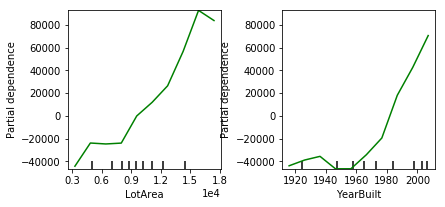

In [9]:
cols_to_use = ['LotArea', 'YearBuilt']
X = X[cols_to_use]
model = GradientBoostingRegressor()
gbr_pipeline = make_pipeline(SimpleImputer(), model)
gbr_pipeline.fit(X, y)
my_plots = plot_partial_dependence(model, 
                                   features=[0,1], 
                                   X=X, 
                                   feature_names=cols_to_use, 
                                   grid_resolution=10)

In [8]:
scores = cross_val_score(gbr_pipeline, X, y, scoring='neg_mean_absolute_error', cv=5)
print('Mean Absolute Error %.2f' %(-1 * scores.mean()))

Mean Absolute Error 36342.81


#### Conclusion

The XGBoostRegressor model didn't give us better results compared to RandomForest. More research is needed for determining best parameters to use and also we can go back to feature engineering.